In [ ]:
# in this notebook varya is trying to fit the model to classify DF and FF 
# based on some features of the catchments (such as morphometrics and/or climate stuff)

In [ ]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

# i will try to use this tutorial

# XGBoost models represent all problems as a regression predictive modeling problem that only takes numerical values as input. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import xgboost
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.inspection import permutation_importance
import shap 




### read data

 - make sure it has the target value X (1/0 -> DF/FF)
 - make sure its only 1 and 0 (not anything else) 
 - make categorical data categorical 
 - calculate correlations and scatter plots to look at how data looks 
 - make histograms for all features (to see how data looks like for different classes)
 - normalize with the z-score (just curious if it will change smth?)
 

In [61]:
# read data: 

# in the copy table i have changed the FF/DF column 
# df = pd.read_csv('morphometrical_params.csv', sep = ';', index_col = 0)
# df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/10_datawrangl_formodel!!/morphometrical_params.csv', sep = ';', index_col = 0)
# df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/10_datawrangl_formodel!!/morphometrical_params_and_climate1.csv', sep = ',', index_col = 0)

# df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/10_datawrangl_formodel!!/morph_temperature_NOmonsoon.csv', sep = ',', index_col = 0)


path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
df = pd.read_csv(path + 'dfclim_3aug_rainydays.csv', sep = ',', index_col = 0)


df = df[df.target.isin([1,0])]
df = df.drop(['DN','Unnamed: 0.1', 'Name'], axis = 1)
# reset FF/DF to 0 and 1
# all - flood, some - DF

In [62]:
df

,target,x_centroid,y_centroid,area_m,perimeter,glaciersum,mean_elevation,median_elevation,std_elevation,min_elevation,...,belowzero_frac,avgtemp_belowzero,mean_annual_tp,mean_annualsum_tp,mean_daylymonsoon_tp_x,mean_daylymonsoon_tp_y,mean_monsoon_sum_tp,monsoon_tp_frac,n_rainy_days,rainy_days_frac
0,1,6533932.497,-500205.440,323908.568,3584.675,0.000,4738.964789,4764.5,184.324936,4136.0,...,0.667380,1,6.923016,2528.59840,11.198315,11.198315,65577.330,25.934260,148.37500,0.406507
1,1,6534113.836,-500799.045,182483.700,2922.889,0.000,4568.158333,4594.5,148.640450,4192.0,...,0.667380,1,6.923016,2528.59840,11.198315,11.198315,65577.330,25.934260,148.37500,0.406507
3,1,6533894.325,-503821.445,205294.163,2702.293,0.000,4182.414815,4179.0,149.451064,3875.0,...,0.667380,1,6.923016,2528.59840,11.198315,11.198315,65577.330,25.934260,148.37500,0.406507
7,0,6531952.768,-502250.739,8413968.867,19907.851,2763.123,4867.525384,4886.5,386.837657,3891.0,...,0.667380,1,6.923016,2528.59840,11.198315,11.198315,65577.330,25.934260,148.37500,0.406507
8,0,6535837.722,-503989.910,359644.959,3750.121,0.000,4346.589852,4321.0,195.953906,3992.0,...,0.667380,1,6.923016,2528.59840,11.198315,11.198315,65577.330,25.934260,148.37500,0.406507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,1,5907050.424,-1195549.440,1284828.337,6069.585,0.000,5628.424171,5622.0,190.356445,5230.0,...,0.693236,1,1.279911,467.46150,1.487208,1.487208,8709.087,18.630598,20.53125,0.056250
1180,1,5908114.850,-1195174.890,2358816.953,9545.802,0.000,5394.825105,5370.0,290.575365,4887.0,...,0.693236,1,1.279911,467.46150,1.487208,1.487208,8709.087,18.630598,20.53125,0.056250
1181,1,5908413.450,-1193969.040,2622176.316,10483.829,0.000,5583.418578,5611.0,316.972253,4919.0,...,0.693236,1,1.279911,467.46150,1.487208,1.487208,8709.087,18.630598,20.53125,0.056250
1182,1,5909758.971,-1193073.120,3833933.847,10870.075,0.000,5311.430018,5253.0,347.465894,4717.0,...,0.694007,1,1.241337,453.37402,1.505284,1.505284,8814.943,19.442984,19.87500,0.054452


In [5]:
# df.head()
# df.describe()
# sns.pairplot(df, hue='target', size=2.5) # this is the scatter plot for all values 


# df.dtypes

# df.columns

df['region_name'].value_counts()

tadjikistan       233
karakorum         166
chitral            89
eastTSH            84
interior tibet     84
langtang           32
nyanq              24
Name: region_name, dtype: int64

In [6]:
# 

# df['glacier']=df['glacier'].astype('category')
# df['region']=df['region'].astype('category')



In [7]:
# df = df[df.region.isin([7])]


Text(0.5, 1.0, 'morphometry parameters')

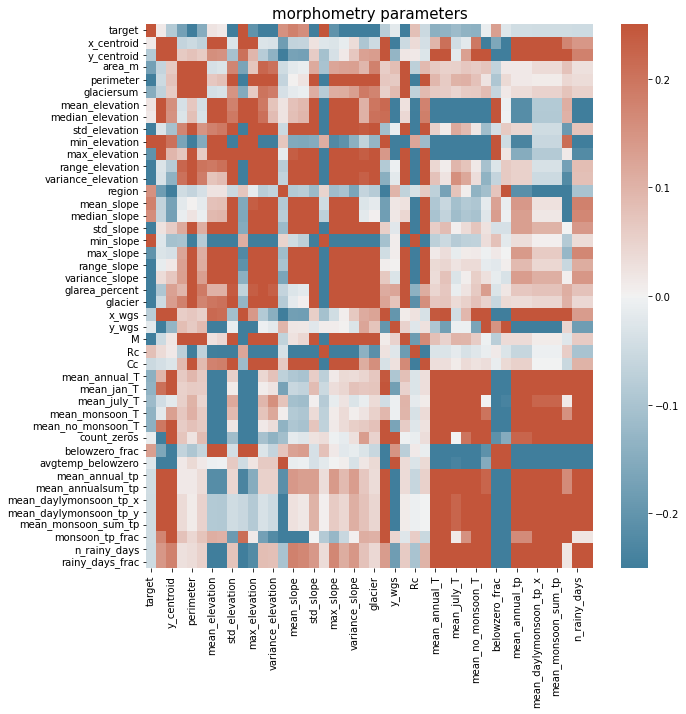

In [63]:
# correlations
df_corr = df.corr()


# plot

plt.figure(figsize=(10, 10))

# mask for the upper triangle
# mask = np.triu(np.ones_like(df_corr, dtype=bool))
# color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# heatmap 
# sns.heatmap(df_corr, cmap=cmap, mask = mask)
sns.heatmap(df_corr, cmap=cmap, vmin = -0.25, vmax = 0.25)
plt.title('morphometry parameters', fontsize = 15)



In [62]:
# scatter plot (stupid one for now) 
# g = sns.PairGrid(df, hue = 'target')
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)

# plt.savefig('params_scatter_sub.png', dpi = 300, bbox_inches = 'tight')


In [63]:
# scale the data with the z score: 
# df1 = df

In [64]:
# z score (#!!! maybe think about not including region number here) 

# df = df[['area_m', 'perimeter', 'glaciersum', 'mean_elevation', 'median_elevation', 
         # 'std_elevation', 'min_elevation', 'max_elevation', 'range_elevation',
         # 'variance_elevation', 'region', 'mean_slope', 'median_slope', 'std_slope', 
         # 'min_slope', 'max_slope', 'range_slope',
         # 'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M', 'Rc', 'Cc']]

# dfz = df.apply(zscore)
# dfz.head()

In [65]:
# dfz

# model stuff

##### NB!!!! DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:Catchment_Area_km, ksn_m09


(read for example this for the nice explanation: https://towardsdatascience.com/xgboost-python-example-42777d01001e)

In [66]:
# try for data scaled with z score:
# df = dfz
# df

In [64]:
# subset the data: 

df.columns

Index(['target', 'x_centroid', 'y_centroid', 'area_m', 'perimeter',
       'glaciersum', 'mean_elevation', 'median_elevation', 'std_elevation',
       'min_elevation', 'max_elevation', 'range_elevation',
       'variance_elevation', 'region', 'region_name', 'mean_slope',
       'median_slope', 'std_slope', 'min_slope', 'max_slope', 'range_slope',
       'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M',
       'Rc', 'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T',
       'mean_monsoon_T', 'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_x', 'mean_daylymonsoon_tp_y',
       'mean_monsoon_sum_tp', 'monsoon_tp_frac', 'n_rainy_days',
       'rainy_days_frac'],
      dtype='object')

In [65]:
x_columns = ['x_centroid', 'y_centroid', 'area_m',
       'perimeter', 'glaciersum', 'mean_elevation', 'median_elevation',
       'std_elevation', 'min_elevation', 'max_elevation', 'range_elevation',
       'variance_elevation', 'region', 'mean_slope',
       'median_slope', 'std_slope', 'min_slope', 'max_slope', 'range_slope',
       'variance_slope', 'glarea_percent', 'glacier', 'M',
       'Rc', 'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T',
       'mean_monsoon_T', 'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_x', 'mean_daylymonsoon_tp_y',
       'mean_monsoon_sum_tp', 'monsoon_tp_frac', 'n_rainy_days',
       'rainy_days_frac']
y_column = ['target']

In [66]:
# ------- split data into X and y
X = df[x_columns]
y = df[y_column]

In [67]:
# ------- split to train test: 

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [68]:
## ----- model parameters 
print('default xgboost parameters:')
# xgboost.XGBClassifier().get_params()

# hyperparameters tuning example here:
# https://github.com/harsh1kumar/learning/blob/master/machine_learning/santander_trxn_prediction/07_trxn_pred_xgboost.ipynb

default xgboost parameters:


In [69]:
# 1. fit model to training data       # XGBClassifier isnt nice 
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
# clf = xgb.XGBClassifier(tree_method="gpu_hist", enable_categorical=True)

model = XGBClassifier(n_estimators=1000, depth=5)#, tree_method="hist", enable_categorical=True)#, enable_categorical=True)
model.fit(X_train, y_train)

[23:18:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              depth=5, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [70]:
# print(model)

In [71]:
# 5. Make Predictions - class:

# make predictions for test data
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

# evaluate predictions:
# accuracy = accuracy_score(y_test, predictions)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Accuracy — measures the fraction of correct predictions')
# Accuracy =(True Positive + True Negative)/(True Positive + True Negative+ False Positive+ False Negative)

  


Accuracy: 87.41%
Accuracy — measures the fraction of correct predictions


In [74]:
# predict probability (not class) 

probs = model.predict_proba(X_test)
# 2 columns: (1) 0 is true, (2) 1 is true
# therefore take the 2nd column:
probs = probs[:,1]



In [75]:
# random guess: 

print('random guess chanses with this data split: %.2f%%' % (555/738 * 100))#df/total 

random guess chanses with this data split: 75.20%


### model evaluation/validation stuff: (todo)

(read some more stuff here: https://medium.com/analytics-vidhya/10-essential-ways-to-evaluate-machine-learning-model-performance-6bf6e11f9502)

 - ROC curve and AUC 
 - precision/recall curve 
 - F1 score 
 - confusion matrix
 - cross validation( k10 -?)
 
 - hyperparameters: how many estimators, how many trees ect (see this for example: https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/) 
 
 

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

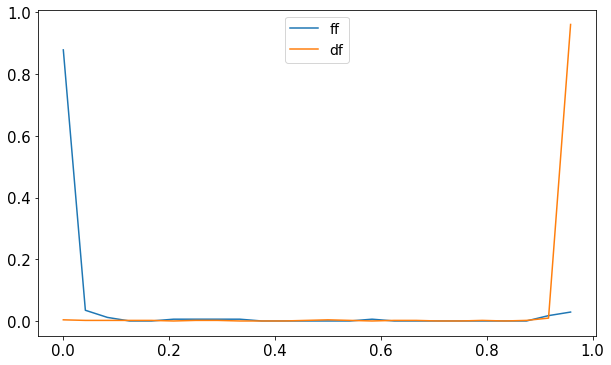

In [76]:
# ------- probability distributions plot:

# calculate probabilities 
# split into 2 classes 

debris = df[df.target.isin([1,])] # df
flood = df[df.target.isin([0,])]  # ff 

# split data into X and y
Xdebris = debris[x_columns]
ydebris = debris[y_column]

Xflood = flood[x_columns]
yflood = flood[y_column]

# debris:
dfprobs = model.predict_proba(Xdebris)
dfprobs = dfprobs[:,1]
# floods:
ffprobs = model.predict_proba(Xflood)
ffprobs = ffprobs[:,1]



# ------- histograms (normalized)

fig, ax = plt.subplots(figsize = (10,6))
# normalize histogram (example)
h, e = np.histogram(ffprobs, bins=np.linspace(0, 1, 25))
ax.plot(e[:-1], h/h.sum(), label = 'ff')

hd, ed = np.histogram(dfprobs, bins=np.linspace(0, 1, 25))
ax.plot(ed[:-1], hd/hd.sum(), label = 'df')

plt.legend(fontsize = 14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# this "histogram" plot shows the distribution of the "predicted" probabilities per class 
# default threshold to classify things is 50%

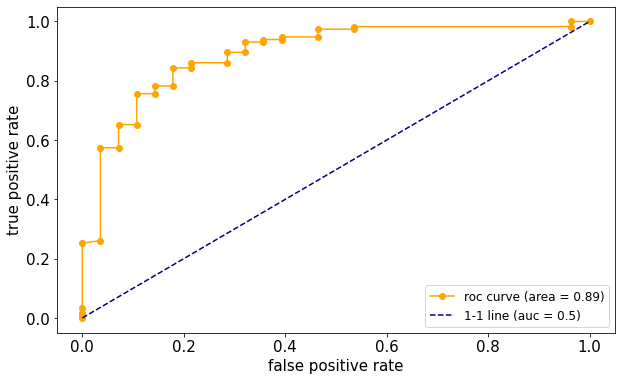

In [80]:
### ------ ROC curve: 
# plot of the false positive rate (x-axis) мы the true positive rate (y-axis) 
# for a number of different candidate threshold values between 0.0 and 1.0. 
# (in other way, it plots the false alarm rate versus the hit rate)
# the default probability for classification is 50% 
# this curve shows what would FPrate and TPrate have been, if the threshold was different
# A model with no skill is represented at the point (0.5, 0.5).
# A model with no skill at each threshold is represented by a diagonal 1-1 line and has an AUC of 0.5.

# ROC shows the ability of the model to predict a higher score for positive examples as compared to negative examples.

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)


fig, ax = plt.subplots(figsize = (10,6))
plt.plot(fpr, tpr, color = 'orange', marker='o', label = 'roc curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label = '1-1 line (auc = 0.5)')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate',fontsize=15)
plt.legend(fontsize=12)

# thresholds

# plt.savefig('figs/xgboost_xgboost_roc.pdf')

In [79]:
print('thresholds for roc curve: \n\n', sorted(thresholds))

thresholds for roc curve: 

 [8.114658e-06, 0.0002257719, 0.00051236455, 0.0749988, 0.0771273, 0.110111564, 0.23123792, 0.28068882, 0.30785233, 0.31546497, 0.33692873, 0.4905705, 0.6215983, 0.64264506, 0.92625785, 0.93737864, 0.95050526, 0.95574975, 0.9881522, 0.9883548, 0.99388933, 0.9947917, 0.99855036, 0.99859744, 0.9994698, 0.99953663, 0.9999708, 0.9999721, 0.99999857, 0.9999989, 0.9999994, 1.9999994]


### precision recall curve 

In [226]:
# len(thresholds)

In [81]:
## ------- confusion matrix: 
# (table that is used to define the performance of a classification algorithm)
# TP | FN
# --- ---
# FP | TN


confmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n', confmatrix)

# 26+10+6+106

confusion matrix: 
 [[ 19   9]
 [  9 106]]


In [82]:
## ----- precision

precision = precision_score(y_test, y_pred)
print('precision score:', round(precision, 3))
# print(' measures the fraction of actual positives among those examples that are predicted as positive.
# print('It shows the probability that a predicted ‘Yes’ is actually a ‘Yes’')
print('precision = True Positive/True Positive+False Positive')
    

precision score: 0.922
precision = True Positive/True Positive+False Positive


In [83]:
### ------ f1 score 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

f1score = f1_score(y_test, y_pred)
print('f1 score:', round(f1score, 3))
print('f1score: F1 = 2 * (precision * recall) / (precision + recall)')

f1 score: 0.922
f1score: F1 = 2 * (precision * recall) / (precision + recall)


In [84]:
### --------- recall score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# Recall — measures how many actual positives were predicted as positive.
# It is the probability that an actual ‘Yes’ case is predicted correctly

recallscore = recall_score(y_test, y_pred)
print('recall score:', recallscore)
print('recall score: tp / (tp + fn)')

recall score: 0.9217391304347826
recall score: tp / (tp + fn)


In [85]:
# ----------- k-Fold Cross Validation

kfold = KFold(n_splits=10)#, random_state=7, shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# k fold splits the data to pieces ('folds') and then trains and tests the model on k-1 folds (leaving one "out") 
# this way the accuracy that you get in the end is the mean value of the "each" training and testing thing
# basically there is a new "model" created fot each round of k-1 folds 

[23:20:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboos

## model meaning: 

 - what features are important for the model: gain and weight (plots here) 

<AxesSubplot:>

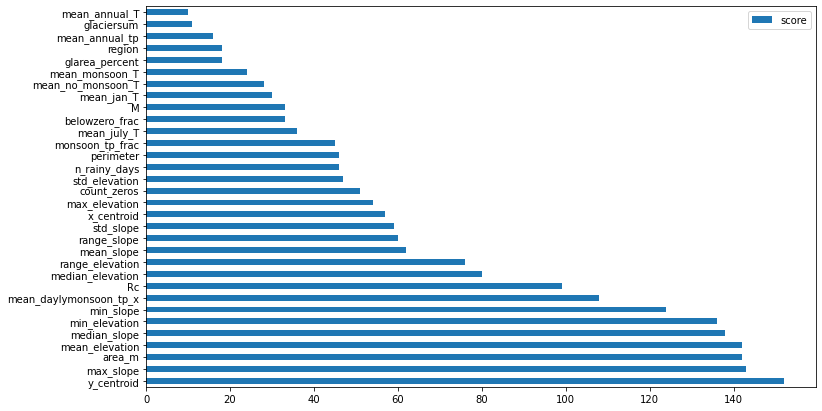

In [87]:
# built in thing 
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (12,7)) 

# plt.savefig('figs/feature_weight.pdf')

In [86]:
# plot feature importance

# plot_importance(model)

<BarContainer object of 41 artists>

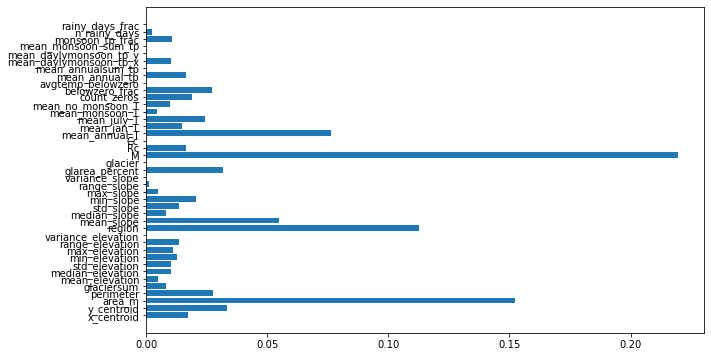

In [88]:
# X = pd.DataFrame(boston.data, columns=boston.feature_names)
# y = boston.target

fig, ax = plt.subplots(figsize = (10,6))
plt.barh(x_columns, model.feature_importances_)


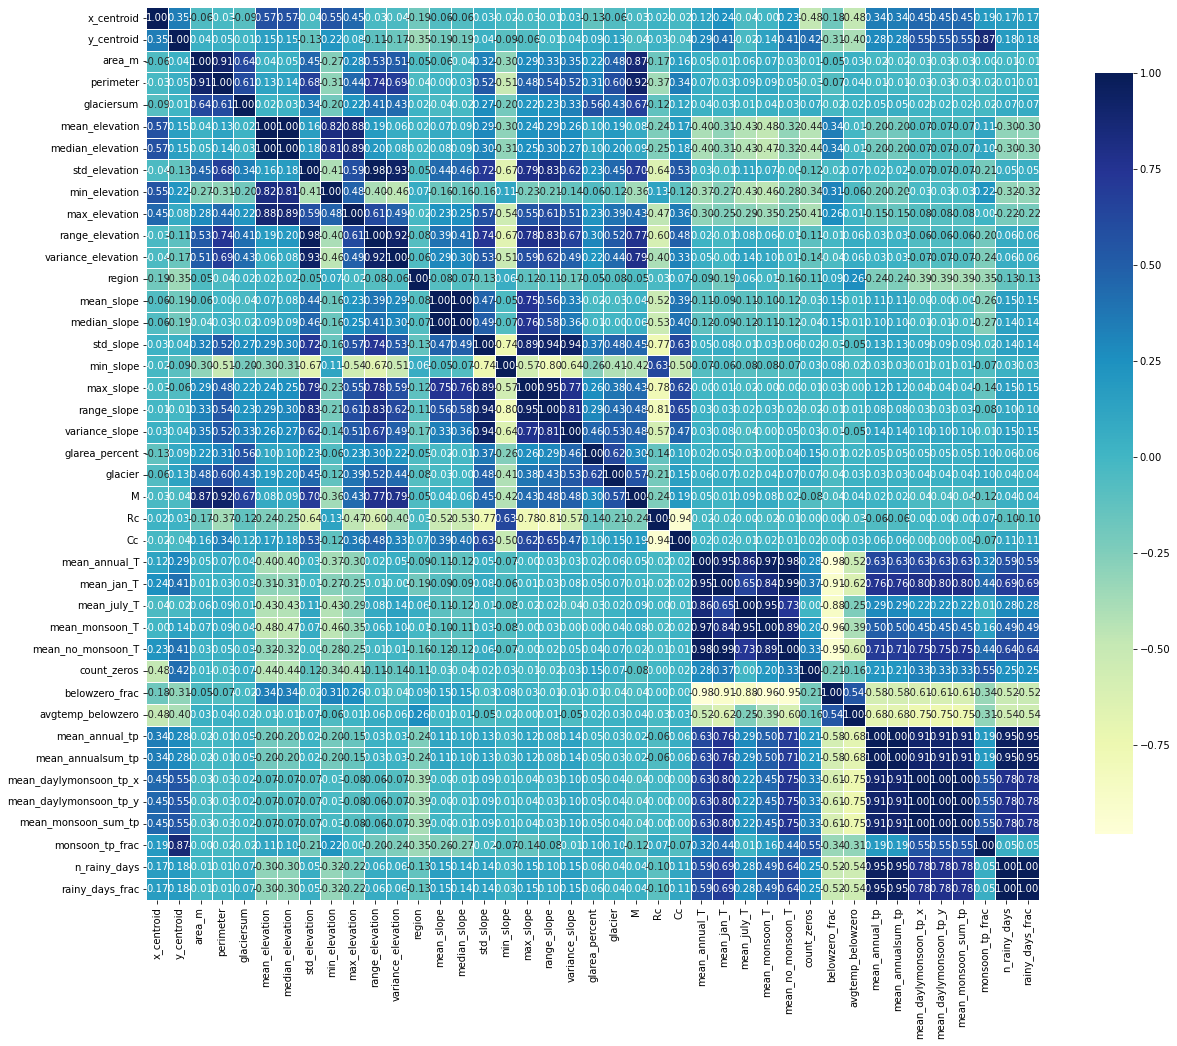

In [89]:
# feature correlation:

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[x_columns])

In [92]:
# shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

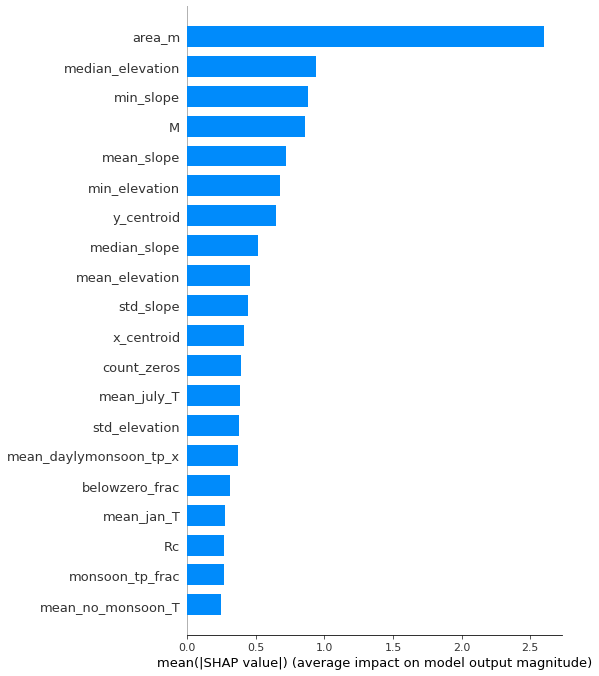

In [93]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


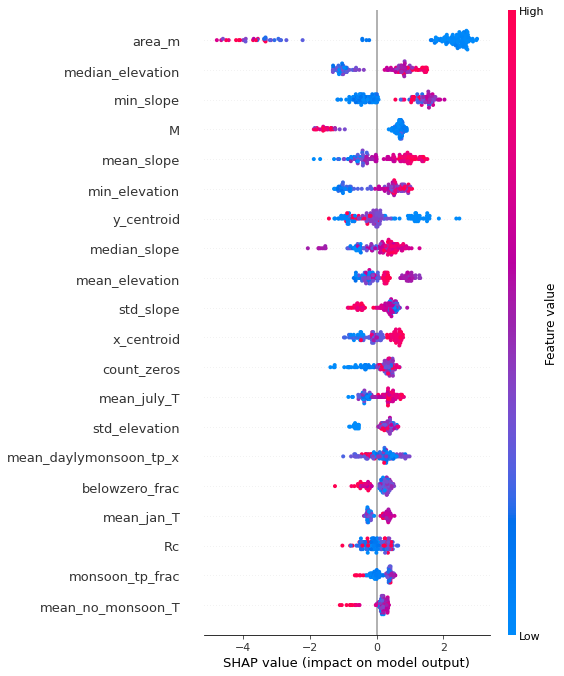

In [94]:
shap.summary_plot(shap_values, X_test)

# shap.plots.bar(shap_values[0])
# shap.plots.force(shap_values[0])

# plt.savefig('shap_summary_beeswarm.pdf')

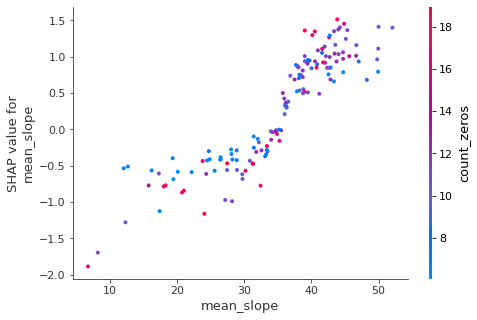

In [95]:
shap.dependence_plot("mean_slope", shap_values, X_test)

In [96]:
# other feature importances: 

# available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'total_cover'
model.get_booster().get_score(importance_type= f)

{'x_centroid': 458.925537109375,
 'y_centroid': 1236.4276123046875,
 'area_m': 1513.6744384765625,
 'perimeter': 188.5011444091797,
 'glaciersum': 42.58723831176758,
 'mean_elevation': 587.0146484375,
 'median_elevation': 432.44000244140625,
 'std_elevation': 184.3670654296875,
 'min_elevation': 651.6058959960938,
 'max_elevation': 193.06407165527344,
 'range_elevation': 276.93145751953125,
 'region': 208.66587829589844,
 'mean_slope': 652.9480590820312,
 'median_slope': 681.7633666992188,
 'std_slope': 337.6447448730469,
 'min_slope': 624.6595458984375,
 'max_slope': 491.10455322265625,
 'range_slope': 182.0934600830078,
 'glarea_percent': 78.25325775146484,
 'M': 529.6909790039062,
 'Rc': 553.3257446289062,
 'mean_annual_T': 110.41377258300781,
 'mean_jan_T': 130.12069702148438,
 'mean_july_T': 237.1448974609375,
 'mean_monsoon_T': 81.2420654296875,
 'mean_no_monsoon_T': 155.9572296142578,
 'count_zeros': 345.1736755371094,
 'belowzero_frac': 268.06890869140625,
 'mean_annual_tp': 11

In [97]:
## overall todo: 
# - play around with model tuning and make sure you have optimal hyperparameters (all these model evaluation plots etc) 
# - evaluation 
# meaning things 

In [98]:
# actually you have to follow this as a tutorial: 
# https://xgboost.readthedocs.io/en/stable/get_started.html

### apply the model 

In [99]:
y_result = model.predict(X)

y_result_probs = model.predict_proba(X)
y_result_probs = y_result_probs[:,1]

In [100]:
df['y_result'] = y_result
df['y_result_probs'] = y_result_probs

In [101]:

# plot which catchments failed 

len(y_result)
# df.columns

712

# partial dependence stuff

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


(0.0, 1.0)

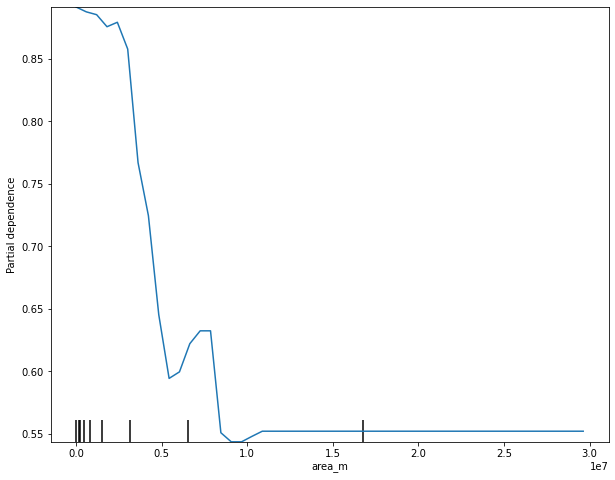

In [106]:
# see this as background: 
# https://christophm.github.io/interpretable-ml-book/pdp.html

from sklearn.inspection import partial_dependence, plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim(0, 1)

my_plots = plot_partial_dependence(model,       
                                   features=['area_m'],       # column numbers of plots we want to show
                                   X=X,                        # raw predictors data.
                                   grid_resolution=50,
                                   response_method='predict_proba'
                                  ,ax=ax)  # number of values to plot on x axis
ax.set_ylim(0, 1)

# plt.savefig('figs/pdp_mean_elev.pdf')

In [47]:
y, x = partial_dependence(model,       
                                   features=['perimeter'],       # column numbers of plots we want to show
                                   X=X,                        # raw predictors data.
                                   grid_resolution=738,
                                   response_method='predict_proba')

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


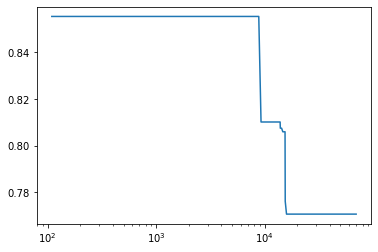

In [48]:
plt.plot(x[0], y[0])
plt.xscale('log')

In [208]:
Pr = model.predict_proba(X)[:,1]
Pr.mean()

0.75825316